# Importing libraries

In [4]:
import os
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam

# To read images/ prepare feature vector and convert labels to one hot encoded vectors

In [39]:
def one_hot_encode_labels(labels):
    """
    Convert labels into one-hot encoded vectors.
    
    Parameters:
        labels: List or 1D array of integers (0-9).

    Returns:
        one_hot_labels: 2D NumPy array of shape (n_samples, 10).
    """
    n_samples = len(labels)
    one_hot_labels = np.zeros((n_samples, 10))
    one_hot_labels[np.arange(n_samples), labels] = 1
    return one_hot_labels


def extract_features(image):
    """
    Extract features from a 28x28 image by flattening it into a 1D array.
    
    Parameters:
        image: 2D NumPy array (28x28) - grayscale image.

    Returns:
        features: 1D NumPy array (784) - flattened image.
    """
    return image.flatten()


def preprocess_dataset(image_folder_path):
    """
    Process images and labels for a digit recognition model.

    Parameters:
        image_folder_path: Path to the dataset folder containing subfolders 0-9.

    Returns:
        features_array: 2D NumPy array (n_samples, 784) - flattened image features.
        one_hot_labels: 2D NumPy array (n_samples, 10) - one-hot encoded labels.
    """
    features_list = []
    labels_list = []

    # Traverse folders (0-9)
    for label in range(10):
        label_folder = os.path.join(image_folder_path, str(label))
        for filename in os.listdir(label_folder):
            file_path = os.path.join(label_folder, filename)

            # Open and process the image
            image = Image.open(file_path).convert('L')  # Convert to grayscale since not all pictures are black and white like the dataset.
            image = np.array(image) / 255.0  # Normalize pixel values to [0, 1]
            features = extract_features(image)

            # Append features and label
            features_list.append(features)
            labels_list.append(label)

    # Convert to NumPy arrays
    features_array = np.array(features_list)
    one_hot_labels = one_hot_encode_labels(labels_list)

    return features_array, one_hot_labels


image_folder_path = r"C:\Users\vijay\Documents\digit_rec\trainingSet\trainingSet"  # Replace with your dataset path
features_array, one_hot_labels = preprocess_dataset(image_folder_path)

print("Feature Array Shape:", features_array.shape)  # Should be (n_samples, 784)
print("One-Hot Labels Shape:", one_hot_labels.shape)  # Should be (n_samples, 10)


Feature Array Shape: (42000, 784)
One-Hot Labels Shape: (42000, 10)


# ReLu and it's derivative

In [42]:
def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return np.where(x > 0, 1, 0)

# Softmax Function

In [45]:
def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

# Loss Function

In [48]:
def cross_entropy_loss(y_true, y_pred):
    # Categorical cross-entropy loss with a small value epsilon to avoid log(0)
    return -np.mean(np.sum(y_true * np.log(y_pred + 1e-8), axis=1))

# Training the NN

In [78]:
# Initialize neural network parameters
input_size = 784
hidden_layer_1_size = 512
hidden_layer_2_size = 128
output_size = 10
learning_rate = 0.001
epochs = 50
batch_size = 128

# Random seed for reproducibility
np.random.seed(42)

# Initialize weights and biases
w1 = np.random.randn(input_size, hidden_layer_1_size) * 0.01
b1 = np.zeros((1, hidden_layer_1_size))

w2 = np.random.randn(hidden_layer_1_size, hidden_layer_2_size) * 0.01
b2 = np.zeros((1, hidden_layer_2_size))

w3 = np.random.randn(hidden_layer_2_size, output_size) * 0.01
b3 = np.zeros((1, output_size))

# Adam optimizer state variables (momentum, velocity)
m_w1, v_w1 = np.zeros_like(w1), np.zeros_like(w1)
m_b1, v_b1 = np.zeros_like(b1), np.zeros_like(b1)
m_w2, v_w2 = np.zeros_like(w2), np.zeros_like(w2)
m_b2, v_b2 = np.zeros_like(b2), np.zeros_like(b2)
m_w3, v_w3 = np.zeros_like(w3), np.zeros_like(w3)
m_b3, v_b3 = np.zeros_like(b3), np.zeros_like(b3)

beta1, beta2 = 0.9, 0.999  # Adam parameters
epsilon = 1e-8  # For numerical stability

# Learning rate decay
lr_scheduler = lambda epoch: learning_rate * max(0.95 ** epoch, 1e-6)

# Train-test split
x_train, x_test, y_train, y_test = train_test_split(features_array, one_hot_labels, test_size=0.2, random_state=42)

# Training loop
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    num_batches = int(x_train.shape[0] / batch_size)
    
    for batch in range(num_batches):
        # Get the current batch
        start = batch * batch_size
        end = start + batch_size
        X_batch = x_train[start:end]
        y_batch = y_train[start:end]
        
        # Forward pass
        z1 = np.dot(X_batch, w1) + b1
        a1 = relu(z1)
        
        z2 = np.dot(a1, w2) + b2
        a2 = relu(z2)
        
        z3 = np.dot(a2, w3) + b3
        y_pred = softmax(z3)

        # Calculate loss
        loss = cross_entropy_loss(y_batch, y_pred)
        epoch_loss += loss
        
        # Calculate accuracy
        accuracy = np.mean(np.argmax(y_pred, axis=1) == np.argmax(y_batch, axis=1))
        epoch_accuracy += accuracy

        # Backpropagation
        # Output layer gradients
        dz3 = y_pred - y_batch  # Gradient of loss w.r.t output layer
        dw3 = np.dot(a2.T, dz3) / batch_size
        db3 = np.sum(dz3, axis=0, keepdims=True) / batch_size
        
        # Hidden layer 2 gradients
        dz2 = np.dot(dz3, w3.T) * relu_derivative(a2)
        dw2 = np.dot(a1.T, dz2) / batch_size
        db2 = np.sum(dz2, axis=0, keepdims=True) / batch_size
        
        # Hidden layer 1 gradients
        dz1 = np.dot(dz2, w2.T) * relu_derivative(a1)
        dw1 = np.dot(X_batch.T, dz1) / batch_size
        db1 = np.sum(dz1, axis=0, keepdims=True) / batch_size
        
        # Adam optimizer parameter update
        for param, grad, m, v, lr in zip([w1, w2, w3], [dw1, dw2, dw3], [m_w1, m_w2, m_w3], [v_w1, v_w2, v_w3], [lr_scheduler(epoch)] * 3):
            m = beta1 * m + (1 - beta1) * grad
            v = beta2 * v + (1 - beta2) * np.square(grad)
            m_hat = m / (1 - beta1 ** (epoch + 1))  # Bias correction
            v_hat = v / (1 - beta2 ** (epoch + 1))  # Bias correction
            param -= lr * m_hat / (np.sqrt(v_hat) + epsilon)

        for param, grad, m, v, lr in zip([b1, b2, b3], [db1, db2, db3], [m_b1, m_b2, m_b3], [v_b1, v_b2, v_b3], [lr_scheduler(epoch)] * 3):
            m = beta1 * m + (1 - beta1) * grad
            v = beta2 * v + (1 - beta2) * np.square(grad)
            m_hat = m / (1 - beta1 ** (epoch + 1))  # Bias correction
            v_hat = v / (1 - beta2 ** (epoch + 1))  # Bias correction
            param -= lr * m_hat / (np.sqrt(v_hat) + epsilon)

    # Epoch metrics
    print(f"Epoch {epoch + 1}/{epochs} - Loss: {epoch_loss/num_batches:.4f}, Accuracy: {epoch_accuracy/num_batches:.4f}")
    
    # Validation loss and accuracy after every epoch
    z1_val = np.dot(x_test, w1) + b1
    a1_val = relu(z1_val)
    z2_val = np.dot(a1_val, w2) + b2
    a2_val = relu(z2_val)
    z3_val = np.dot(a2_val, w3) + b3
    y_pred_val = softmax(z3_val)
    
    val_loss = cross_entropy_loss(y_test, y_pred_val)
    val_accuracy = np.mean(np.argmax(y_pred_val, axis=1) == np.argmax(y_test, axis=1))
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    print(f"Learning rate: {lr}","\n")

Epoch 1/50 - Loss: 0.6598, Accuracy: 0.8030
Validation Loss: 0.3671, Validation Accuracy: 0.8874
Learning rate: 0.001 

Epoch 2/50 - Loss: 0.2855, Accuracy: 0.9168
Validation Loss: 0.2408, Validation Accuracy: 0.9310
Learning rate: 0.00095 

Epoch 3/50 - Loss: 0.2028, Accuracy: 0.9413
Validation Loss: 0.1895, Validation Accuracy: 0.9475
Learning rate: 0.0009025 

Epoch 4/50 - Loss: 0.1633, Accuracy: 0.9538
Validation Loss: 0.1702, Validation Accuracy: 0.9532
Learning rate: 0.000857375 

Epoch 5/50 - Loss: 0.1413, Accuracy: 0.9611
Validation Loss: 0.1603, Validation Accuracy: 0.9574
Learning rate: 0.0008145062499999999 

Epoch 6/50 - Loss: 0.1273, Accuracy: 0.9660
Validation Loss: 0.1542, Validation Accuracy: 0.9618
Learning rate: 0.0007737809374999998 

Epoch 7/50 - Loss: 0.1172, Accuracy: 0.9694
Validation Loss: 0.1508, Validation Accuracy: 0.9631
Learning rate: 0.0007350918906249999 

Epoch 8/50 - Loss: 0.1095, Accuracy: 0.9718
Validation Loss: 0.1487, Validation Accuracy: 0.9640
Lea

# TensorFlow model for comparison

In [85]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

# Build the model
model = Sequential([
    Input(shape=(784,)),               # input layer
    Dense(256, activation='relu'),     # hidden layer 1
    Dense(64, activation='relu'),      # hidden layer 2
    Dense(10, activation='softmax')    # output layer
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, epochs=50, batch_size=128, validation_data=(x_test, y_test))

Epoch 1/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8048 - loss: 0.6761 - val_accuracy: 0.9421 - val_loss: 0.2018
Epoch 2/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9519 - loss: 0.1596 - val_accuracy: 0.9583 - val_loss: 0.1385
Epoch 3/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9698 - loss: 0.1003 - val_accuracy: 0.9657 - val_loss: 0.1214
Epoch 4/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9780 - loss: 0.0728 - val_accuracy: 0.9649 - val_loss: 0.1103
Epoch 5/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9849 - loss: 0.0512 - val_accuracy: 0.9681 - val_loss: 0.0990
Epoch 6/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9871 - loss: 0.0414 - val_accuracy: 0.9670 - val_loss: 0.1059
Epoch 7/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9926 - loss: 0.0272 - val_accuracy: 0.9689 - val_loss: 0.1077
Epoch 8/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9950 - loss: 0.0214 - val_accuracy: 0.

# Attach image for prediction

## Instructions:

1. Take a photo of the number.
    
2. Crop the photo such that there is not a lot of empty space between the number and the borders of the image.

<div style="margin-left: 40px;">

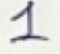

</div>
    
4. Resize the image to 28x28 and convert it to a .jpg file.

<div style="margin-left: 40px;">



</div>
    
6. Invert the image's colours.

<div style="margin-left: 40px;">



</div>
    
8. Copy the path of the image file into the cell and hit run!

In [87]:
def predict(x_in):
    # Forward pass through the network
    z1 = np.dot(x_in, w1) + b1
    a1 = relu(z1)
    z2 = np.dot(a1, w2) + b2
    a2 = relu(z2)
    z3 = np.dot(a2, w3) + b3
    y_pred = softmax(z3)

    # Get the index of the maximum value (predicted number)
    return np.argmax(y_pred)

# Load the image
image_path = r"C:\Users\vijay\Documents\test_images\image (2).jpg"
image = Image.open(image_path).convert('L')  # Convert to grayscale since not all pictures are black and white like the dataset.
image = np.array(image) / 255.0  # Normalize pixel values to [0, 1]

# Extract features (e.g., flatten the image)
x_in = extract_features(image)

# Predict the class of the input image
predicted_class = predict(x_in)

print(f"Predicted class: {predicted_class}")

Predicted class: 1
